In [13]:
%pip install torch torchvision torch lightning
import torch
from torch import nn
import torch.nn.functional as F
import lightning as L
import torchmetrics
from torchvision import datasets, transforms, models
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create directory for saving checkpoints and plots
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("plots", exist_ok=True)



In [14]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    transforms.Grayscale()
])

test_transforms = transforms.Compose([
    transforms.CenterCrop(160),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
    transforms.Grayscale()
])

# Load datasets
download = False
if not os.path.exists("./data/imagenette"):
    download = True
train_dataset = datasets.Imagenette("data/imagenette/train/", split="train", size="160px", download=download, transform=train_transforms)
test_dataset = datasets.Imagenette("data/imagenette/test/", split="val", size="160px", download=download, transform=test_transforms)

# Split into training and validation
train_set_size = int(len(train_dataset) * 0.9)
val_set_size = len(train_dataset) - train_set_size

seed = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_set_size, val_set_size], generator=seed)
val_dataset.dataset.transform = test_transforms

# Reduce dataset size for quick testing
# def reduce_dataset(dataset, fraction=0.1):
#     reduced_size = int(len(dataset) * fraction)
#     _, reduced_dataset = torch.utils.data.random_split(dataset, [len(dataset) - reduced_size, reduced_size], generator=torch.Generator().manual_seed(42))
#     return reduced_dataset

# train_dataset = reduce_dataset(train_dataset, 0.05)
# val_dataset = reduce_dataset(val_dataset, 0.05)
# test_dataset = reduce_dataset(test_dataset, 0.05)

# Data loaders for reduced dataset
train_loader = DataLoader(train_dataset, batch_size=128, num_workers=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, num_workers=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=256, num_workers=8, shuffle=False)



INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name                 | Type               | Params | Mode 
--------------------------------------------------------------------
0 | convolutionalLayer1  | Conv2d             | 320    | train
1 | convolutionalLayer2  | Conv2d             | 18.5 K | train
2 | maxPoolingLayer      | MaxPool2d          | 0      | train
3 | fullyConnectedLayer1 | Linear             | 2.1 M  | train
4 | fullyConnectedLayer2 | Linear             | 1.3 K  | train
5 | accuracyMetric       | MulticlassAccuracy | 0      | train
--------------------------------------------------------------------
2.1 M     Trainable params
0         Non-trai

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

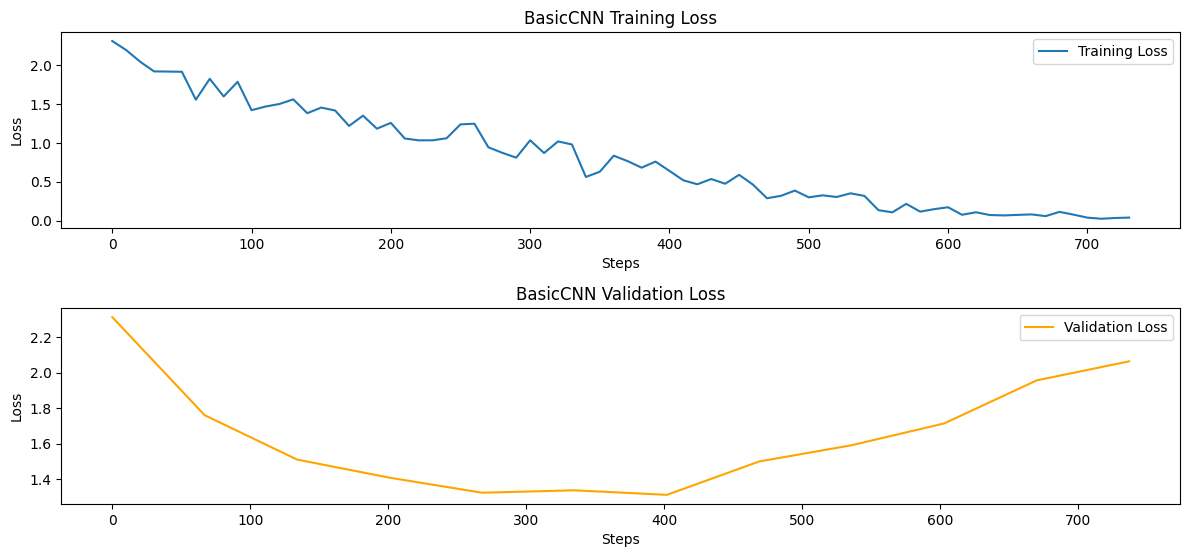

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5628025531768799     │
│         test_loss         │    1.4256922006607056     │
└───────────────────────────┴───────────────────────────┘

In [15]:
class BasicCNN(L.LightningModule):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.convolutionalLayer1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.convolutionalLayer2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxPoolingLayer = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fullyConnectedLayer1 = nn.Linear(64 * 16 * 16, 128)
        self.fullyConnectedLayer2 = nn.Linear(128, 10)
        self.accuracyMetric = torchmetrics.Accuracy(task="multiclass", num_classes=10)
        self.trainingLossList = []
        self.validationLossList = []
        self.testingLossList = []
        self.validationResultsList = []

    def forward(self, inputTensor):
        tensorAfterConv1 = self.maxPoolingLayer(F.relu(self.convolutionalLayer1(inputTensor)))
        tensorAfterConv2 = self.maxPoolingLayer(F.relu(self.convolutionalLayer2(tensorAfterConv1)))
        flattenedTensor = tensorAfterConv2.view(-1, 64 * 16 * 16)
        tensorAfterFc1 = F.relu(self.fullyConnectedLayer1(flattenedTensor))
        outputTensor = self.fullyConnectedLayer2(tensorAfterFc1)
        return outputTensor

    def training_step(self, batch, batchIndex):
        inputBatch, targetBatch = batch
        predictedOutput = self(inputBatch)
        lossValue = F.cross_entropy(predictedOutput, targetBatch)
        accuracyValue = self.accuracyMetric(predictedOutput, targetBatch)

        if self.global_step % 10 == 0:
            self.trainingLossList.append((self.global_step, lossValue.item()))
            self._record_metrics("metrics_log.txt", "Train", lossValue.item(), accuracyValue.item())

        self.log('train_loss', lossValue, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_accuracy', accuracyValue, on_step=False, on_epoch=True, prog_bar=True)
        return lossValue

    def validation_step(self, batch, batchIndex):
        inputBatch, targetBatch = batch
        predictedOutput = self(inputBatch)
        lossValue = F.cross_entropy(predictedOutput, targetBatch)
        accuracyValue = self.accuracyMetric(predictedOutput, targetBatch)
        self.validationResultsList.append({'val_loss': lossValue, 'val_acc': accuracyValue})
        return {'val_loss': lossValue, 'val_acc': accuracyValue}

    def on_validation_epoch_end(self):
        averageLossValue = torch.stack([x['val_loss'] for x in self.validationResultsList]).mean()
        averageAccuracyValue = torch.stack([x['val_acc'] for x in self.validationResultsList]).mean()

        self.validationLossList.append((self.global_step, averageLossValue.item()))
        self._record_metrics("metrics_log.txt", "Val", averageLossValue.item(), averageAccuracyValue.item())

        self.log('val_loss', averageLossValue, on_epoch=True, prog_bar=True)
        self.log('val_accuracy', averageAccuracyValue, on_epoch=True, prog_bar=True)
        self.validationResultsList.clear()

    def test_step(self, batch, batchIndex):
        inputBatch, targetBatch = batch
        predictedOutput = self(inputBatch)
        lossValue = F.cross_entropy(predictedOutput, targetBatch)
        accuracyValue = self.accuracyMetric(predictedOutput, targetBatch)

        self.testingLossList.append((self.global_step, lossValue.item()))
        self._record_metrics("metrics_log.txt", "Test", lossValue.item(), accuracyValue.item())

        self.log('test_loss', lossValue, on_epoch=True, prog_bar=True)
        self.log('test_accuracy', accuracyValue, on_epoch=True, prog_bar=True)
        return lossValue

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def _record_metrics(self, logFileName, phaseName, lossValue, accuracyValue):
        with open(logFileName, "a") as logFile:
            logFile.write(f"Global Step {self.global_step}: {phaseName} Loss = {lossValue}, {phaseName} Accuracy = {accuracyValue}\n")


# Utility Functions
def setupCallbacks():
    earlyStoppingCallback = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    modelCheckpointCallback = ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        dirpath="checkpoints/",
        filename="convolutional_neural_network"
    )
    return earlyStoppingCallback, modelCheckpointCallback

def initializeTrainer(earlyStoppingCallback, modelCheckpointCallback):
    return L.Trainer(
        callbacks=[earlyStoppingCallback, modelCheckpointCallback],
        max_epochs=50,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        log_every_n_steps=10
    )

def saveAndLogMetrics(model, modelCheckpointCallback):
    bestModelPath = modelCheckpointCallback.best_model_path
    torch.save(model.state_dict(), f"checkpoints/convolutional_neural_network_weights.pt")

    with open("checkpoints/convolutional_neural_network_weights.txt", "w") as weightFile:
        weightFile.write(f"Best model weights for BasicCNN saved at: {bestModelPath}\n")

    with open("BasicCNN_Metrics.txt", 'a') as metricsFile:
        try:
            metricsFile.write(f"Final Training Loss: {model.trainingLossList[-1][1]}, Final Training Accuracy: {model.accuracyMetric.compute()}\n")
            metricsFile.write(f"Final Validation Loss: {model.validationLossList[-1][1]}, Final Validation Accuracy: {model.accuracyMetric.compute()}\n")
            metricsFile.write(f"Final Testing Loss: {model.testingLossList[-1][1]}, Final Testing Accuracy: {model.accuracyMetric.compute()}\n")
            metricsFile.write(f"Best Validation Loss: {min(model.validationLossList, key=lambda x: x[1])}, Best Validation Accuracy: {model.accuracyMetric.compute()}\n")
            metricsFile.write(f"Best Testing Loss: {min(model.testingLossList, key=lambda x: x[1])}, Best Testing Accuracy: {model.accuracyMetric.compute()}\n")
            metricsFile.write(f"Best Training Loss: {min(model.trainingLossList, key=lambda x: x[1])}, Best Training Accuracy: {model.accuracyMetric.compute()}\n")
            metricsFile.write(f"Best Model Path: {bestModelPath}\n")
            metricsFile.write(f"Model Summary: {model}\n")
        except:
            pass

def plotMetrics(logFileName, modelName):
    stepCounts, trainLosses, valLosses, testLosses, validationSteps = [], [], [], [], []

    with open(logFileName, "r") as logFile:
        for line in logFile:
            if "Train Loss" in line:
                stepCount = int(float(line.split(" ")[2].split(":")[0].strip()))
                lossValue = float(line.split("=")[1].split(",")[0].strip())
                stepCounts.append(stepCount)
                trainLosses.append(lossValue)
            elif "Val Loss" in line:
                stepCount = int(float(line.split(" ")[2].split(":")[0].strip()))
                lossValue = float(line.split("=")[1].split(",")[0].strip())
                valLosses.append(lossValue)
                validationSteps.append(stepCount)
            elif "Test Loss" in line:
                lossValue = float(line.split("=")[1].split(",")[0].strip())
                testLosses.append(lossValue)

    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    plt.plot(stepCounts, trainLosses, label="Training Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"{modelName} Training Loss")

    plt.subplot(3, 1, 2)
    plt.plot(validationSteps, valLosses, label="Validation Loss", color="orange")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"{modelName} Validation Loss")

    plt.tight_layout()
    plt.savefig(f"plots/{modelName}_loss_plot.png")
    plt.show()


# Main Execution
if __name__ == "__main__":
    neuralNetworkModel = BasicCNN()
    if os.path.exists("metrics_log.txt"):
        os.remove("metrics_log.txt")

    earlyStoppingCallback, modelCheckpointCallback = setupCallbacks()
    trainerInstance = initializeTrainer(earlyStoppingCallback, modelCheckpointCallback)

    # Train the model
    trainerInstance.fit(neuralNetworkModel, train_dataloaders=train_loader, val_dataloaders=val_loader)

    # Load the best model
    neuralNetworkModel = BasicCNN.load_from_checkpoint(modelCheckpointCallback.best_model_path)

    # Save and log metrics
    saveAndLogMetrics(neuralNetworkModel, modelCheckpointCallback)

    # Plot the metrics
    plotMetrics("metrics_log.txt", "BasicCNN")

    # Evaluate on test set
    trainerInstance.test(neuralNetworkModel, dataloaders=test_loader)


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | resNetModel    | ResNet             | 11.2 M | train
1 | accuracyMetric | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.701    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | resNetModel    | ResNet  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

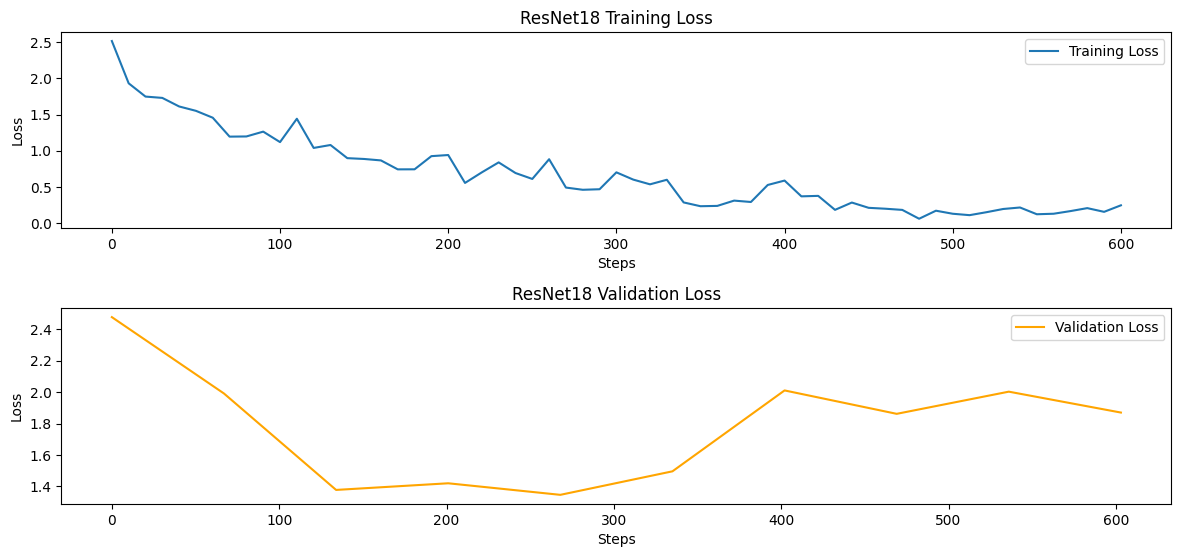

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5551592111587524     │
│         test_loss         │     1.501777172088623     │
└───────────────────────────┴───────────────────────────┘

In [16]:
# Define ResNet18 model
class ResNet18(L.LightningModule):
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        self.resNetModel = models.resnet18(pretrained=False)
        self.resNetModel.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resNetModel.fc = nn.Linear(self.resNetModel.fc.in_features, num_classes)
        self.accuracyMetric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.trainingLossList = []
        self.validationLossList = []
        self.testingLossList = []
        self.validationResultsList = []

    def forward(self, inputTensor):
        return self.resNetModel(inputTensor)

    def training_step(self, batch, batchIndex):
        inputBatch, targetBatch = batch
        predictedOutput = self(inputBatch)
        lossValue = F.cross_entropy(predictedOutput, targetBatch)
        accuracyValue = self.accuracyMetric(predictedOutput, targetBatch)

        if self.global_step % 10 == 0:
            self.trainingLossList.append((self.global_step, lossValue.item()))
            self._record_metrics("resnet_metrics_log.txt", "Train", lossValue.item(), accuracyValue.item())

        self.log('train_loss', lossValue, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_accuracy', accuracyValue, on_step=False, on_epoch=True, prog_bar=True)
        return lossValue

    def validation_step(self, batch, batchIndex):
        inputBatch, targetBatch = batch
        predictedOutput = self(inputBatch)
        lossValue = F.cross_entropy(predictedOutput, targetBatch)
        accuracyValue = self.accuracyMetric(predictedOutput, targetBatch)
        self.validationResultsList.append({'val_loss': lossValue, 'val_acc': accuracyValue})
        return {'val_loss': lossValue, 'val_acc': accuracyValue}

    def on_validation_epoch_end(self):
        averageLossValue = torch.stack([x['val_loss'] for x in self.validationResultsList]).mean()
        averageAccuracyValue = torch.stack([x['val_acc'] for x in self.validationResultsList]).mean()

        self.validationLossList.append((self.global_step, averageLossValue.item()))
        self._record_metrics("resnet_metrics_log.txt", "Val", averageLossValue.item(), averageAccuracyValue.item())

        self.log('val_loss', averageLossValue, on_epoch=True, prog_bar=True)
        self.log('val_accuracy', averageAccuracyValue, on_epoch=True, prog_bar=True)
        self.validationResultsList.clear()

    def test_step(self, batch, batchIndex):
        inputBatch, targetBatch = batch
        predictedOutput = self(inputBatch)
        lossValue = F.cross_entropy(predictedOutput, targetBatch)
        accuracyValue = self.accuracyMetric(predictedOutput, targetBatch)

        self.testingLossList.append((self.global_step, lossValue.item()))
        self._record_metrics("resnet_metrics_log.txt", "Test", lossValue.item(), accuracyValue.item())

        self.log('test_loss', lossValue, on_epoch=True, prog_bar=True)
        self.log('test_accuracy', accuracyValue, on_epoch=True, prog_bar=True)
        return lossValue

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def _record_metrics(self, logFileName, phaseName, lossValue, accuracyValue):
        with open(logFileName, "a") as logFile:
            logFile.write(f"Global Step {self.global_step}: {phaseName} Loss = {lossValue}, {phaseName} Accuracy = {accuracyValue}\n")


# Utility Functions
def setupCallbacks():
    earlyStoppingCallback = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    modelCheckpointCallback = ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        dirpath="checkpoints/",
        filename="resnet18"
    )
    return earlyStoppingCallback, modelCheckpointCallback

def initializeTrainer(earlyStoppingCallback, modelCheckpointCallback):
    return L.Trainer(
        callbacks=[earlyStoppingCallback, modelCheckpointCallback],
        max_epochs=50,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        log_every_n_steps=10
    )

def saveAndLogMetrics(model, modelCheckpointCallback):
    bestModelPath = modelCheckpointCallback.best_model_path
    torch.save(model.state_dict(), f"checkpoints/resnet18_weights.pt")

    with open("checkpoints/resnet18_weights.txt", "w") as weightFile:
        weightFile.write(f"Best model weights for ResNet18 saved at: {bestModelPath}\n")

    with open("ResNet18_Metrics.txt", 'a') as metricsFile:
        try:
            metricsFile.write(f"Final Training Loss: {model.trainingLossList[-1][1]}, Final Training Accuracy: {model.accuracyMetric.compute()}\n")
            metricsFile.write(f"Final Validation Loss: {model.validationLossList[-1][1]}, Final Validation Accuracy: {model.accuracyMetric.compute()}\n")
            metricsFile.write(f"Final Testing Loss: {model.testingLossList[-1][1]}, Final Testing Accuracy: {model.accuracyMetric.compute()}\n")
            metricsFile.write(f"Best Validation Loss: {min(model.validationLossList, key=lambda x: x[1])}, Best Validation Accuracy: {model.accuracyMetric.compute()}\n")
            metricsFile.write(f"Best Testing Loss: {min(model.testingLossList, key=lambda x: x[1])}, Best Testing Accuracy: {model.accuracyMetric.compute()}\n")
            metricsFile.write(f"Best Training Loss: {min(model.trainingLossList, key=lambda x: x[1])}, Best Training Accuracy: {model.accuracyMetric.compute()}\n")
            metricsFile.write(f"Best Model Path: {bestModelPath}\n")
            metricsFile.write(f"Model Summary: {model}\n")
        except:
            pass

def plotMetrics(logFileName, modelName):
    stepCounts, trainLosses, valLosses, testLosses, validationSteps = [], [], [], [], []

    with open(logFileName, "r") as logFile:
        for line in logFile:
            if "Train Loss" in line:
                stepCount = int(float(line.split(" ")[2].split(":")[0].strip()))
                lossValue = float(line.split("=")[1].split(",")[0].strip())
                stepCounts.append(stepCount)
                trainLosses.append(lossValue)
            elif "Val Loss" in line:
                stepCount = int(float(line.split(" ")[2].split(":")[0].strip()))
                lossValue = float(line.split("=")[1].split(",")[0].strip())
                valLosses.append(lossValue)
                validationSteps.append(stepCount)
            elif "Test Loss" in line:
                lossValue = float(line.split("=")[1].split(",")[0].strip())
                testLosses.append(lossValue)

    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    plt.plot(stepCounts, trainLosses, label="Training Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"{modelName} Training Loss")

    plt.subplot(3, 1, 2)
    plt.plot(validationSteps, valLosses, label="Validation Loss", color="orange")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"{modelName} Validation Loss")

    plt.tight_layout()
    plt.savefig(f"plots/{modelName}_loss_plot.png")
    plt.show()


# Main Execution
if __name__ == "__main__":
    resNetModel = ResNet18()
    if os.path.exists("resnet_metrics_log.txt"):
        os.remove("resnet_metrics_log.txt")

    earlyStoppingCallback, modelCheckpointCallback = setupCallbacks()
    trainerInstance = initializeTrainer(earlyStoppingCallback, modelCheckpointCallback)

    # Train the model
    trainerInstance.fit(resNetModel, train_dataloaders=train_loader, val_dataloaders=val_loader)

    # Load the best model
    resNetModel = ResNet18.load_from_checkpoint(modelCheckpointCallback.best_model_path)

    # Save and log metrics
    saveAndLogMetrics(resNetModel, modelCheckpointCallback)

    # Plot the metrics
    plotMetrics("resnet_metrics_log.txt", "ResNet18")

    # Evaluate on test set
    trainerInstance.test(resNetModel, dataloaders=test_loader)


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name                 | Type               | Params | Mode 
--------------------------------------------------------------------
0 | convolutionalLayer1  | Conv2d             | 320    | train
1 | convolutionalLayer2  | Conv2d             | 18.5 K | train
2 | maxPoolingLayer      | MaxPool2d          | 0      | train
3 | fullyConnectedLayer1 | Linear             | 2.1 M  | train
4 | fullyConnectedLayer2 | Linear             | 1.3 K  | train
5 | accuracyMetric       | MulticlassAccuracy | 0      | train
--------------------------------------------------------------------
2.1 M     Trainable params
0         Non-trai

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

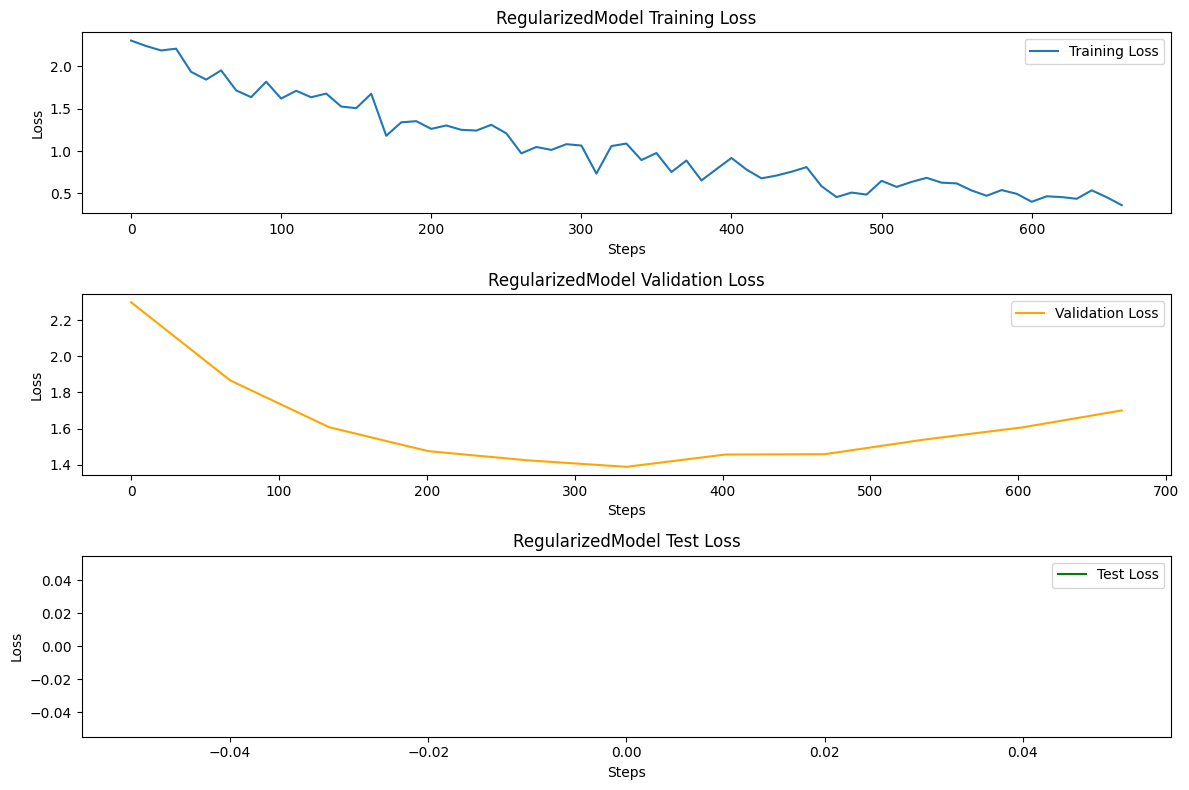

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5429299473762512     │
│         test_loss         │    1.4538490772247314     │
└───────────────────────────┴───────────────────────────┘

In [17]:
# Define RegularizedModel
class RegularizedModel(L.LightningModule):
    def __init__(self, num_classes=10):
        super().__init__()
        self.convolutionalLayer1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.convolutionalLayer2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.maxPoolingLayer = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fullyConnectedLayer1 = nn.Linear(64 * 16 * 16, 128)
        self.fullyConnectedLayer2 = nn.Linear(128, num_classes)
        self.accuracyMetric = torchmetrics.Accuracy(task="multiclass", num_classes=num_classes)
        self.trainingLossList = []
        self.validationLossList = []
        self.testingLossList = []
        self.validationResultsList = []

    def forward(self, x):
        x = self.maxPoolingLayer(F.relu(self.convolutionalLayer1(x)))
        x = self.maxPoolingLayer(F.relu(self.convolutionalLayer2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fullyConnectedLayer1(x))
        x = F.relu(self.fullyConnectedLayer2(x))
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracyMetric(y_hat, y)

        if self.global_step % 10 == 0:
            self.trainingLossList.append((self.global_step, loss.item()))
            self._record_metrics("regularized_model_metrics_log.txt", "Train", loss.item(), acc.item())

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_accuracy', acc, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracyMetric(y_hat, y)
        self.validationResultsList.append({'val_loss': loss, 'val_acc': acc})
        return {'val_loss': loss, 'val_acc': acc}

    def on_validation_epoch_end(self):
        avg_loss = torch.stack([x['val_loss'] for x in self.validationResultsList]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in self.validationResultsList]).mean()

        self.validationLossList.append((self.global_step, avg_loss.item()))
        self._record_metrics("regularized_model_metrics_log.txt", "Val", avg_loss.item(), avg_acc.item())

        self.log('val_loss', avg_loss, on_epoch=True, prog_bar=True)
        self.log('val_accuracy', avg_acc, on_epoch=True, prog_bar=True)
        self.validationResultsList.clear()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.accuracyMetric(y_hat, y)

        self.testingLossList.append((self.global_step, loss.item()))
        self._record_metrics("regularized_model_metrics_log.txt", "Test", loss.item(), acc.item())

        self.log('test_loss', loss, on_epoch=True, prog_bar=True)
        self.log('test_accuracy', acc, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def _record_metrics(self, logFileName, phaseName, lossValue, accuracyValue):
        with open(logFileName, "a") as logFile:
            logFile.write(f"Global Step {self.global_step}: {phaseName} Loss = {lossValue}, {phaseName} Accuracy = {accuracyValue}\n")


# Utility Functions
def setupCallbacks():
    earlyStoppingCallback = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    modelCheckpointCallback = ModelCheckpoint(
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        dirpath="checkpoints/",
        filename="regularized_model"
    )
    return earlyStoppingCallback, modelCheckpointCallback

def initializeTrainer(earlyStoppingCallback, modelCheckpointCallback):
    return L.Trainer(
        callbacks=[earlyStoppingCallback, modelCheckpointCallback],
        max_epochs=50,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        log_every_n_steps=10
    )

def saveAndLogMetrics(model, modelCheckpointCallback):
    bestModelPath = modelCheckpointCallback.best_model_path
    torch.save(model.state_dict(), f"checkpoints/regularized_model_weights.pt")

    with open("checkpoints/regularized_model_weights.txt", "w") as weightFile:
        weightFile.write(f"Best model weights for RegularizedModel saved at: {bestModelPath}\n")

    with open("RegularizedModel_Metrics.txt", 'a') as metricsFile:
        try:
            metricsFile.write(f"Final Training Loss: {model.trainingLossList[-1][1]}, Final Training Accuracy: {model.accuracyMetric.compute()}\n")
            metricsFile.write(f"Final Validation Loss: {model.validationLossList[-1][1]}, Final Validation Accuracy: {model.accuracyMetric.compute()}\n")
            metricsFile.write(f"Final Testing Loss: {model.testingLossList[-1][1]}, Final Testing Accuracy: {model.accuracyMetric.compute()}\n")
            metricsFile.write(f"Best Validation Loss: {min(model.validationLossList, key=lambda x: x[1])}, Best Validation Accuracy: {model.accuracyMetric.compute()}\n")
            metricsFile.write(f"Best Testing Loss: {min(model.testingLossList, key=lambda x: x[1])}, Best Testing Accuracy: {model.accuracyMetric.compute()}\n")
            metricsFile.write(f"Best Training Loss: {min(model.trainingLossList, key=lambda x: x[1])}, Best Training Accuracy: {model.accuracyMetric.compute()}\n")
            metricsFile.write(f"Best Model Path: {bestModelPath}\n")
            metricsFile.write(f"Model Summary: {model}\n")
        except:
            pass

def plotMetrics(logFileName, modelName):
    stepCounts, trainLosses, valLosses, testLosses, validationSteps = [], [], [], [], []

    with open(logFileName, "r") as logFile:
        for line in logFile:
            if "Train Loss" in line:
                stepCount = int(float(line.split(" ")[2].split(":")[0].strip()))
                lossValue = float(line.split("=")[1].split(",")[0].strip())
                stepCounts.append(stepCount)
                trainLosses.append(lossValue)
            elif "Val Loss" in line:
                stepCount = int(float(line.split(" ")[2].split(":")[0].strip()))
                lossValue = float(line.split("=")[1].split(",")[0].strip())
                valLosses.append(lossValue)
                validationSteps.append(stepCount)
            elif "Test Loss" in line:
                lossValue = float(line.split("=")[1].split(",")[0].strip())
                testLosses.append(lossValue)

    plt.figure(figsize=(12, 8))
    plt.subplot(3, 1, 1)
    plt.plot(stepCounts, trainLosses, label="Training Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"{modelName} Training Loss")

    plt.subplot(3, 1, 2)
    plt.plot(validationSteps, valLosses, label="Validation Loss", color="orange")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"{modelName} Validation Loss")

    plt.subplot(3, 1, 3)
    plt.plot(stepCounts[:len(testLosses)], testLosses, label="Test Loss", color="green")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"{modelName} Test Loss")

    plt.tight_layout()
    plt.savefig(f"plots/{modelName}_metrics_plot.png")
    plt.show()


# Main Execution
if __name__ == "__main__":
    regularizedModel = RegularizedModel()
    if os.path.exists("regularized_model_metrics_log.txt"):
        os.remove("regularized_model_metrics_log.txt")

    earlyStoppingCallback, modelCheckpointCallback = setupCallbacks()
    trainerInstance = initializeTrainer(earlyStoppingCallback, modelCheckpointCallback)

    # Train the model
    trainerInstance.fit(regularizedModel, train_dataloaders=train_loader, val_dataloaders=val_loader)

    # Load the best model
    regularizedModel = RegularizedModel.load_from_checkpoint(modelCheckpointCallback.best_model_path)

    # Save and log metrics
    saveAndLogMetrics(regularizedModel, modelCheckpointCallback)

    # Plot the metrics
    plotMetrics("regularized_model_metrics_log.txt", "RegularizedModel")

    # Evaluate on test set
    trainerInstance.test(regularizedModel, dataloaders=test_loader)


INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | accuracyMetric | MulticlassAccuracy | 0      | train
1 | network        | ResNet             | 11.2 M | train
--------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | accuracyMetric | Multicla

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

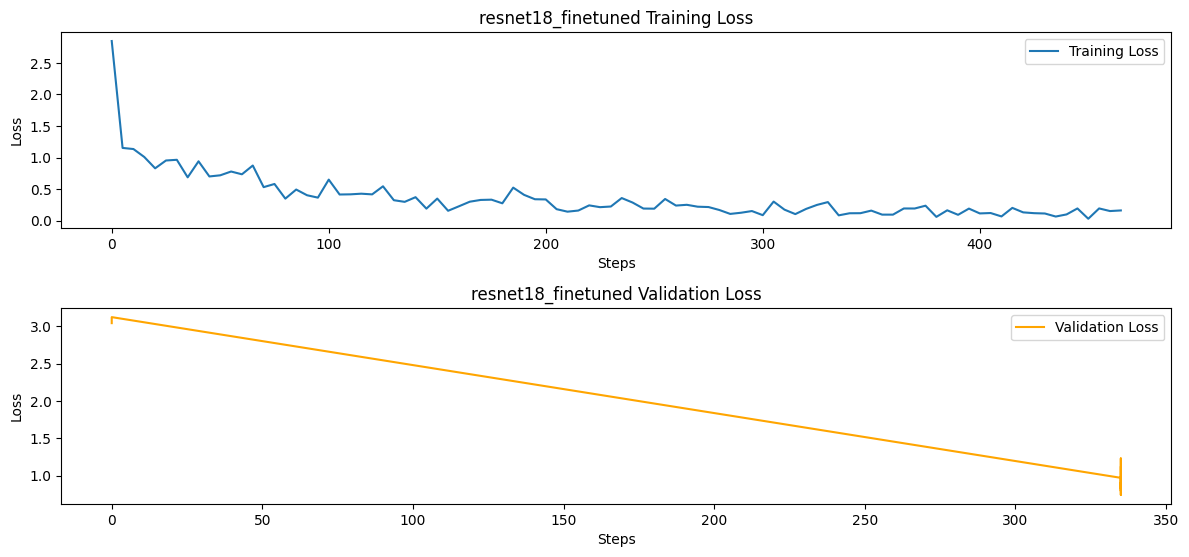

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7666242122650146     │
│         test_loss         │     0.769429624080658     │
└───────────────────────────┴───────────────────────────┘

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | accuracyMetric | MulticlassAccuracy | 0      | train
1 | network        | ResNet             | 11.2 M | train
--------------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | accuracyMetric | Multicla

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

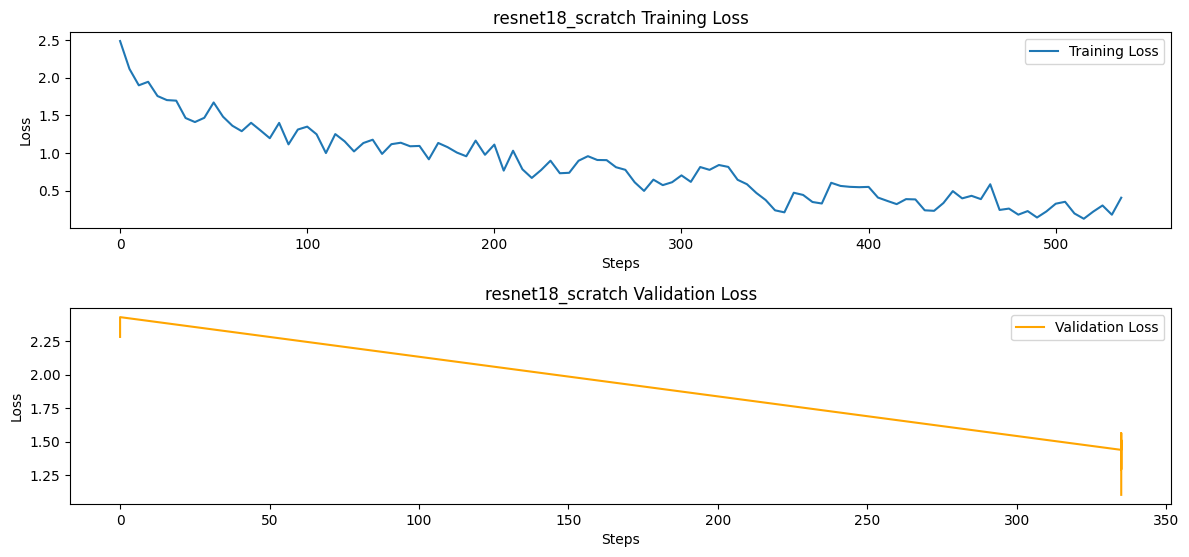

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5299363136291504     │
│         test_loss         │    1.4233157634735107     │
└───────────────────────────┴───────────────────────────┘

In [19]:
# Configuration
classCount = 10
learningRate = 1e-3
epochLimit = 50
earlyStoppingPatience = 5
modelCheckpointDir = "checkpoints/"
plotDirectory = "plots/"
trainingLogFile = "TL_resnet_metrics_log.txt"
scratchLogFile = "TL_resnet_metrics_log_scratch.txt"

# Define TransferLearningModel class
class TransferLearningModel(L.LightningModule):
    def __init__(self, classCount=classCount, usePretrained=False, logFilePath=trainingLogFile):
        super().__init__()
        self.accuracyMetric = torchmetrics.Accuracy(task="multiclass", num_classes=classCount)
        self.network = models.resnet18(pretrained=usePretrained)
        self.network.fc = nn.Linear(self.network.fc.in_features, classCount)
        self.logFilePath = logFilePath
        self.validation_step_outputs = []  # Initialize the list to store validation step outputs

    def forward(self, inputTensor):
        inputTensor = inputTensor.repeat(1, 3, 1, 1)  # Convert single channel to 3 channels if necessary
        return self.network(inputTensor)

    def training_step(self, batch, batchIndex):
        inputTensor, targets = batch
        predictions = self(inputTensor)
        loss = F.cross_entropy(predictions, targets)
        accuracy = self.accuracyMetric(predictions, targets)

        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_accuracy', accuracy, on_step=False, on_epoch=True, prog_bar=True)

        if self.global_step % 5 == 0:
            self._recordMetrics("Train", loss.item(), accuracy.item())

        return loss

    def validation_step(self, batch, batchIndex):
        inputTensor, targets = batch
        predictions = self(inputTensor)
        loss = F.cross_entropy(predictions, targets)
        accuracy = self.accuracyMetric(predictions, targets)

        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_accuracy', accuracy, on_step=False, on_epoch=True, prog_bar=True)

        # Collect validation step outputs
        self.validation_step_outputs.append({'val_loss': loss, 'val_accuracy': accuracy})

        if self.global_step % 5 == 0:
            self._recordMetrics("Val", loss.item(), accuracy.item())

        return {'val_loss': loss, 'val_accuracy': accuracy}

    def on_validation_epoch_end(self):
        if len(self.validation_step_outputs) > 0:  # Check if there are validation step outputs
            # Compute average validation metrics
            avgValidationLoss = torch.stack([x['val_loss'] for x in self.validation_step_outputs]).mean()
            avgValidationAccuracy = torch.stack([x['val_accuracy'] for x in self.validation_step_outputs]).mean()

            self._recordMetrics("ValidationEpochEnd", avgValidationLoss.item(), avgValidationAccuracy.item())
            self.validation_step_outputs.clear()  # Clear the list
        else:
            print("No validation step outputs to aggregate.")

    def test_step(self, batch, batchIndex):
        inputTensor, targets = batch
        predictions = self(inputTensor)
        loss = F.cross_entropy(predictions, targets)
        accuracy = self.accuracyMetric(predictions, targets)

        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('test_accuracy', accuracy, on_step=False, on_epoch=True, prog_bar=True)

        self._recordMetrics("Test", loss.item(), accuracy.item())

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learningRate)
        return optimizer

    def _recordMetrics(self, phase, metricValue, accuracyValue):
        with open(self.logFilePath, "a") as file:
            file.write(f"{phase} Loss at step {self.global_step}: {metricValue}\n")
            file.write(f"{phase} Accuracy at step {self.global_step}: {accuracyValue}\n")

# Define utility function for plotting metrics
def plotTrainingMetrics(logFilePath, modelName):
    steps = []
    trainingLosses = []
    validationLosses = []
    validationSteps = []

    with open(logFilePath, "r") as file:
        for line in file:
            if "Train Loss" in line:
                step = int(line.split(" ")[4].split(":")[0])
                loss = float(line.split(": ")[1])
                steps.append(step)
                trainingLosses.append(loss)
            elif "Val Loss" in line:
                step = int(line.split(" ")[4].split(":")[0])
                loss = float(line.split(": ")[1])
                validationLosses.append(loss)
                validationSteps.append(step)

    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(steps, trainingLosses, label="Training Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"{modelName} Training Loss")

    plt.subplot(3, 1, 2)
    plt.plot(validationSteps, validationLosses, label="Validation Loss", color="orange")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"{modelName} Validation Loss")

    plt.tight_layout()
    os.makedirs(plotDirectory, exist_ok=True)
    plt.savefig(f"{plotDirectory}/{modelName}_loss_plot.png")
    plt.show()

def trainAndEvaluateModel(pretrained, modelName, logFilePath):
    model = TransferLearningModel(classCount=classCount, usePretrained=pretrained, logFilePath=logFilePath)

    if os.path.exists(logFilePath):
        os.remove(logFilePath)

    earlyStoppingCallback = EarlyStopping(monitor="val_loss", mode="min", patience=earlyStoppingPatience)
    checkpointCallback = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1, dirpath=modelCheckpointDir, filename=f"{modelName}")

    trainer = L.Trainer(
        callbacks=[earlyStoppingCallback, checkpointCallback],
        max_epochs=epochLimit,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        log_every_n_steps=10
    )
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

    bestModelPath = checkpointCallback.best_model_path
    model = TransferLearningModel.load_from_checkpoint(bestModelPath)
    torch.save(model.state_dict(), f"{modelCheckpointDir}/{modelName}_weights.pt")

    with open(f"{modelCheckpointDir}/{modelName}_weights.txt", "w") as file:
        file.write(f"Best model weights for {modelName} saved at: {bestModelPath}\n")

    plotTrainingMetrics(logFilePath, modelName)
    trainer.test(model, dataloaders=test_loader)

# Train and evaluate fine-tuned model
trainAndEvaluateModel(pretrained=True, modelName="resnet18_finetuned", logFilePath=trainingLogFile)

# Train and evaluate model from scratch
trainAndEvaluateModel(pretrained=False, modelName="resnet18_scratch", logFilePath=scratchLogFile)
